<a href="https://colab.research.google.com/github/1900690/analog-meter-reading/blob/main/analog_meter_reading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
#@title 分析する画像をアップロードまたはサンプル画像で分析

#事前準備
from google.colab import files
import os
import shutil
サンプル画像を使用する = True # @param {type:"boolean"}
#@markdown ※サンプル画像は、分析ごとに５つの画像の中からランダムで１つ選ばれるようになっています。
if サンプル画像を使用する == True:
  if os.path.exists('/content/test-meter-images.zip'):
     os.remove('/content/test-meter-images.zip')
  if os.path.exists('/content/test-meter-images'):
     shutil.rmtree('/content/test-meter-images')
  !wget -q  https://github.com/1900690/analog-meter-reading/releases/download/sample/test-meter-images.zip
  !unzip -q test-meter-images.zip

else:
  uploaded_file = files.upload()
  uploaded_file_name = next(iter(uploaded_file))

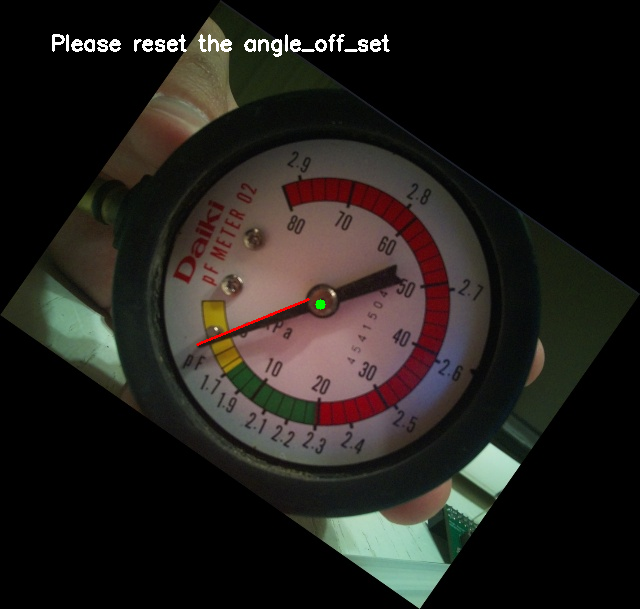

In [46]:
#@title PF値を測定

import cv2
import numpy as np
import math
from google.colab.patches import cv2_imshow
import random

# 画像の読み込み
if サンプル画像を使用する == True:
  folder_path = '/content/test-meter-images'
  files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
  random_file = random.choice(files)
  img = cv2.imread(random_file)
else:
  img = cv2.imread(uploaded_file_name)

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# エッジ検出
edges = cv2.Canny(gray, 50, 150)

# ハフ変換による直線検出
lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=100, minLineLength=50, maxLineGap=10)

# メーターの中心を推定
center = (img.shape[1] // 2, img.shape[0] // 2)

# 針と考えられる最長の線を見つける
longest_line = None
max_length = 0
angle = None
angle_off_set=-49#-25
angle_correction=180

if lines is not None:
    for line in lines:
        x1, y1, x2, y2 = line[0]
        length = math.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)

        # メーターの中心に最も近い点を始点として考える
        if math.sqrt((x1 - center[0]) ** 2 + (y1 - center[1]) ** 2) < math.sqrt((x2 - center[0]) ** 2 + (y2 - center[1]) ** 2):
            start_x, start_y, end_x, end_y = x1, y1, x2, y2
        else:
            start_x, start_y, end_x, end_y = x2, y2, x1, y1

        # メーターの中心からの線のみを考慮
        if length > max_length and math.sqrt((start_x - center[0]) ** 2 + (start_y - center[1]) ** 2) < 50:
            max_length = length
            longest_line = (start_x, start_y, end_x, end_y)
            angle = math.degrees(math.atan2(center[1] - end_y, end_x - center[0]))+angle_off_set+angle_correction
            Kpa=8/27*angle
            if Kpa * 10.197 > 0:
              PH=math.log10(Kpa*10.197)
            else:
              PH=-1

# 針を描画
if longest_line:
    start_x, start_y, end_x, end_y = longest_line
    cv2.line(img, (start_x, start_y), (end_x, end_y), (0, 0, 255), 2)
    cv2.circle(img, center, 5, (0, 255, 0), -1)
    if angle_off_set is not None:
      if PH >0:
        cv2.putText(img, f"{PH:.2f} ph", (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)
      else:
        cv2.putText(img, f"Please reset the angle_off_set", (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)
# 結果の表示
cv2_imshow(img)

##参考文献

1.   [アナログメーターの画像から針の角度を読み取るやつ作ってみた(OpenCV)](https://arkouji.cocolog-nifty.com/blog/2021/09/post-2c82af.html)
2.   [「メーター解析処理」の実装](https://www.primecast.co.jp/columns/8ieb_pgnqe)

